In [1]:
using PyPlot
using LinearAlgebra
using Statistics

In [2]:
abstract type BoundaryCondition end

struct PeriodicBC <: BoundaryCondition end

mutable struct DirichletBC <: BoundaryCondition value :: Float64 end
mutable struct NeumannBC   <: BoundaryCondition value :: Float64 end

DirichletBC() = DirichletBC(0.0)
NeumannBC() = NeumannBC(0.0)
nothing

In [3]:
struct GradientOperator
    nx :: Int64
    δx :: Vector{Float64}
    
    bcs :: Dict{Symbol, BoundaryCondition}
end

calculate_gradient!(dudx, u, δx, n, boundary, bc::PeriodicBC) = begin
    if boundary == :left  @inbounds dudx[1]   = @views (u[1] - u[n]) / (δx[1] + δx[n+1]) end
    if boundary == :right @inbounds dudx[n+1] = @views (u[1] - u[n]) / (δx[1] + δx[n+1]) end
end

calculate_gradient!(dudx, u, δx, n, boundary, bc::DirichletBC) = begin
    if boundary == :left  @inbounds dudx[1]   = @views (u[1] - bc.value)  / (δx[1]) end
    if boundary == :right @inbounds dudx[n+1] = @views (bc.value - u[n]) / (δx[n+1]) end
end

calculate_gradient!(dudx, u, δx, n) = @inbounds dudx[2:n] .= @views (u[2:n] .- u[1:n-1]) ./ δx[2:n]

(∇::GradientOperator)(u; result=nothing, reverse=false) = begin
    δx = ∇.δx
    nx = ∇.nx
    
    dudx = isnothing(result) ? zeros(nx + 1) : result
    
    calculate_gradient!(dudx, u, ∇.δx, ∇.nx)
    for boundary in (:left, :right)
        calculate_gradient!(dudx, u, ∇.δx, ∇.nx, boundary, ∇.bcs[boundary])
    end
    if reverse dudx .*= -1.0 end
    return dudx
end

In [4]:
struct InPlacePeriodicSolver
    nx :: Int64
    Δx :: Vector{Float64}
    δx :: Vector{Float64}
    u  :: Vector{Float64}
    
    tol :: Float64
    maxiter :: Int64
end

InPlacePeriodicSolver(xf; tol=1e-15, maxiter=100) = begin
    Δx = diff(xf)
    nx = length(Δx)
    xc = cumsum(Δx) .- 0.5Δx
    δx = diff([first(xf); xc; last(xf)])
    
    return InPlacePeriodicSolver(nx, Δx, δx, similar(xc), tol, maxiter)
end

apply!(::InPlacePeriodicSolver, ::PeriodicBC) = nothing
solution(ps::InPlacePeriodicSolver) = ps.u
gradient(ps::InPlacePeriodicSolver) = GradientOperator(ps.nx, ps.δx,
    Dict(:left => PeriodicBC(), :right => PeriodicBC()))

gradient (generic function with 1 method)

In [5]:
# iterative methods
function jacobi(x, b; K=100, ϵ=1e-10)
    nx = length(x)
    xi = copy(x)
    xj = similar(x)
    dx = similar(x)
    
    it = K
    for k = 1:K
        dx .= abs.(xi .- xj)
        last_norm = sum(dx)
        @inbounds xj[1] =              (xi[2]       + xi[nx]    + b[1])      / 2.0
        @inbounds xj[2:nx-1] .= @views (xi[1:nx-2] .+ xi[3:nx] .+ b[2:nx-1])./ 2.0
        @inbounds xj[nx]=              (xi[nx-1]    + xi[1]     + b[nx])     / 2.0

        xi, xj = xj, xi

        dx .= abs.(xi .- xj)
        if abs(sum(dx) - last_norm) < ϵ
            it = k
            break
        end
    end
    
    x .= 0.5 .* (xi .+ xj .- mean(xi) .- mean(xj))
    return it
end

function solve!(ps::InPlacePeriodicSolver, rhs)
    b = rhs .* ps.Δx .^ 2 # assembled rhs
    ps.u .= randn(ps.nx)
    jacobi(ps.u, b; K=ps.maxiter, ϵ=ps.tol)
end

solve! (generic function with 1 method)

In [110]:
using SparseArrays

struct LinearSolver
    nx :: Int64
    Δx :: Vector{Float64}
    δx :: Vector{Float64}
    
    A :: SparseMatrixCSC{Float64, Int64}
    b :: Vector{Float64}
    u :: Vector{Float64}
    
    bcs :: Dict{Symbol, BoundaryCondition}
end

LinearSolver(xf) = begin
    Δx = diff(xf)
    nx = length(Δx)
    xc = cumsum(Δx) .- 0.5Δx
    δx = diff([first(xf); xc; last(xf)])
    
    A  = spdiagm(0 => 2ones(nx),
                -1 => -ones(nx-1),
                +1 => -ones(nx-1))
    b  = zeros(nx)
    return LinearSolver(nx, Δx, δx, A, b, similar(xc), Dict())
end

apply!(solver::LinearSolver, bc::PeriodicBC, boundary::Symbol) = begin
    A, n = solver.A, solver.nx
    if boundary == :left  A[1, n] = -1.0 end
    if boundary == :right A[n, 1] = -1.0 end
end

apply!(solver::LinearSolver, bc::DirichletBC, boundary::Symbol) = begin
    A, b = solver.A, solver.b
    n, h = solver.nx, solver.δx
    m = n -1
    
    if boundary == :left
        A[1, 1]+= 6/3
        A[1, 2]-= 1/3
        b[1]   += 8/3 * bc.value
    end
    if boundary == :right
        A[n, n]+= 6/3
        A[n, m]-= 1/3
        b[n]   += 8/3 * bc.value
    end
    
end

solution(ps::LinearSolver) = ps.u
gradient(ps::LinearSolver) = GradientOperator(ps.nx, ps.δx, ps.bcs)

gradient (generic function with 2 methods)

In [111]:
import IterativeSolvers

isperiodic(bc::PeriodicBC) = true
isperiodic(bc) = false

function solve!(ps::LinearSolver, rhs)
    b = ps.b .+ rhs .* ps.Δx .^ 2 # assembled rhs
    ps.u  .= rand(ps.nx)
    IterativeSolvers.cg!(ps.u, ps.A, b)
    if isperiodic(ps.bcs[:left]) &&
       isperiodic(ps.bcs[:right])
        ps.u .-= mean(ps.u)
    end
    return NaN
end

solve! (generic function with 2 methods)

In [112]:
struct MutligridSolver end
struct FastFourierTransformSolver end

In [144]:
xf = 0.0:0.01:1.0
dbc = DirichletBC(-1.0)
bc = PeriodicBC()
ps = LinearSolver(xf)
ps.bcs[:left]  = dbc
ps.bcs[:right] = bc
apply!(ps, ps.bcs[:left],  :left)
apply!(ps, ps.bcs[:right], :right)
xc = 0.5 .* xf[1:end-1] .+
     0.5 .* xf[2:end]
φref = -sin.(2π * 2xc)

f(x) = (2π * 2)^2 * sin(2π * 2x)
ρ = f.(xc)
nothing

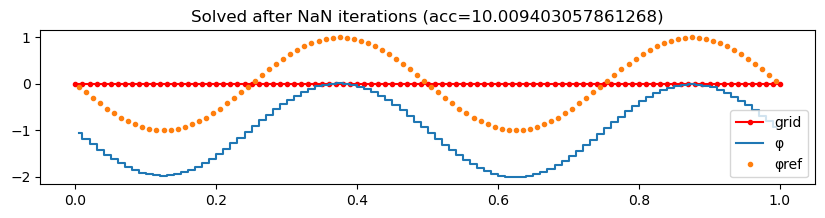

In [145]:
it = solve!(ps, -ρ)
φ  = solution(ps)
figure(figsize=(10, 2))
title("Solved after $it iterations (acc=$(norm(φ - φref)))")
plot(xf, zero(xf), "r.-")
step(xc, φ, where="mid")
plot(xc, φref, ".")
legend(["grid", "φ", "φref"]);

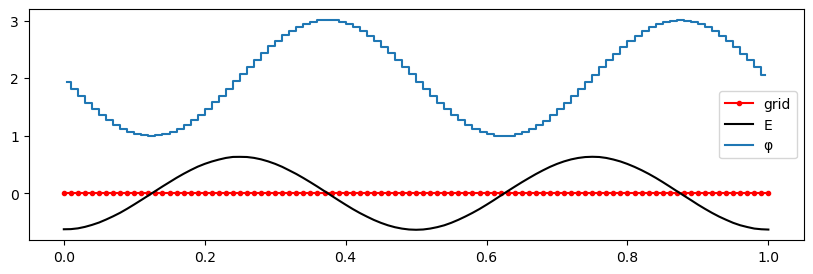

In [141]:
∇ = gradient(ps)
E = ∇(φ)
figure(figsize=(10, 3))
plot(xf, zero(xf), "r.-")
plot(xf, 0.05E, "k-")
step(xc, φ, where="mid")
legend(["grid", "E", "φ"]);